<a href="https://colab.research.google.com/github/DingLi23/s2search/blob/pipelining/pipelining/ale-exp1/ale-exp1_cslg-rand-1000_1w_ale_plotting.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experiment Description

1-way ALE.

> This notebook is for experiment \<ale-exp1\> and data sample \<cslg-rand-1000\>.

### Initialization

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np, sys, os
in_colab = 'google.colab' in sys.modules
# fetching code and data(if you are using colab
if in_colab:
    !rm -rf s2search
    !git clone --branch pipelining https://github.com/youyinnn/s2search.git
    sys.path.insert(1, './s2search')
    %cd s2search/pipelining/ale-exp1/

pic_dir = os.path.join('.', 'plot')
if not os.path.exists(pic_dir):
    os.mkdir(pic_dir)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading data

In [5]:

sys.path.insert(1, '../../')
import numpy as np, sys, os, pandas as pd
from getting_data import read_conf
from s2search_score_pdp import pdp_based_importance

sample_name = 'cslg-rand-1000'

f_list = [
    'title', 'abstract', 'venue', 'authors', 
    'year', 
    'n_citations'
    ]
ale_xy = {}
ale_metric = pd.DataFrame(columns=['feature_name', 'ale_range', 'ale_importance'])

for f in f_list:
    file = os.path.join('.', 'scores', f'{sample_name}_1w_ale_{f}.npz')
    if os.path.exists(file):
        nparr = np.load(file)
        quantile = nparr['quantile']
        ale_result = nparr['ale_result']
        values_for_rug = nparr.get('values_for_rug')
        
        ale_xy[f] = {
            'x': quantile,
            'y': ale_result,
            'rug': values_for_rug,
            'weird': ale_result[len(ale_result) - 1] > 20
        }
        
        if f != 'year' and f != 'n_citations':
            ale_xy[f]['x'] = list(range(len(quantile)))
            ale_xy[f]['numerical'] = False
        else:
            ale_xy[f]['xticks'] = quantile
            ale_xy[f]['numerical'] = True
            
        ale_metric.loc[len(ale_metric.index)] = [f, np.max(ale_result) - np.min(ale_result), pdp_based_importance(ale_result, f)]
               
        # print(len(ale_result))
        
print(ale_metric.sort_values(by=['ale_importance'], ascending=False))
print()
        
des, sample_configs, sample_from_other_exp = read_conf('.')
print(f'The following feature choose quantiles as ale bin size:')
for k in sample_configs['cslg'][0]['quantiles'].keys():
    print(f"	{k} with {sample_configs['cslg'][0]['quantiles'][k]}% quantile, {len(ale_xy[k]['x'])} bins are used")
print(f'The following feature choose fixed amount as ale bin size:')
for k in sample_configs['cslg'][0]['intervals'].keys():
    print(f"	{k} with {sample_configs['cslg'][0]['intervals'][k]} values, {len(ale_xy[k]['x'])} bins are used")


  feature_name  ale_range  ale_importance
1     abstract   5.816953        1.454238
0        title   4.613337        1.153334
4         year   1.230868        0.428393
5  n_citations   1.169302        0.292326
2        venue   0.000000        0.000000
3      authors   0.000000        0.000000

The following feature choose quantiles as ale bin size:
	year with 0.01% quantile, 20 bins are used
	n_citations with 0.01% quantile, 20 bins are used
The following feature choose fixed amount as ale bin size:
	title with 1000 values, 57 bins are used
	abstract with 1000 values, 59 bins are used
	authors with 1000 values, 40 bins are used
	venue with 1000 values, 37 bins are used


### ALE Plots

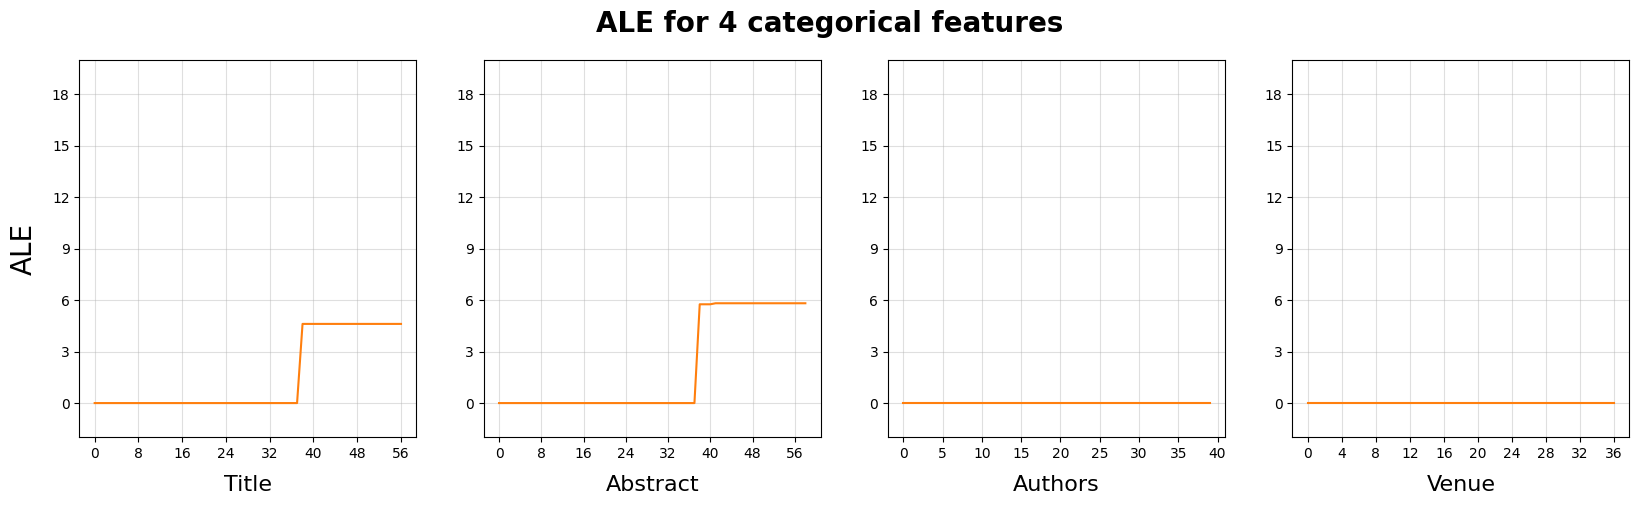

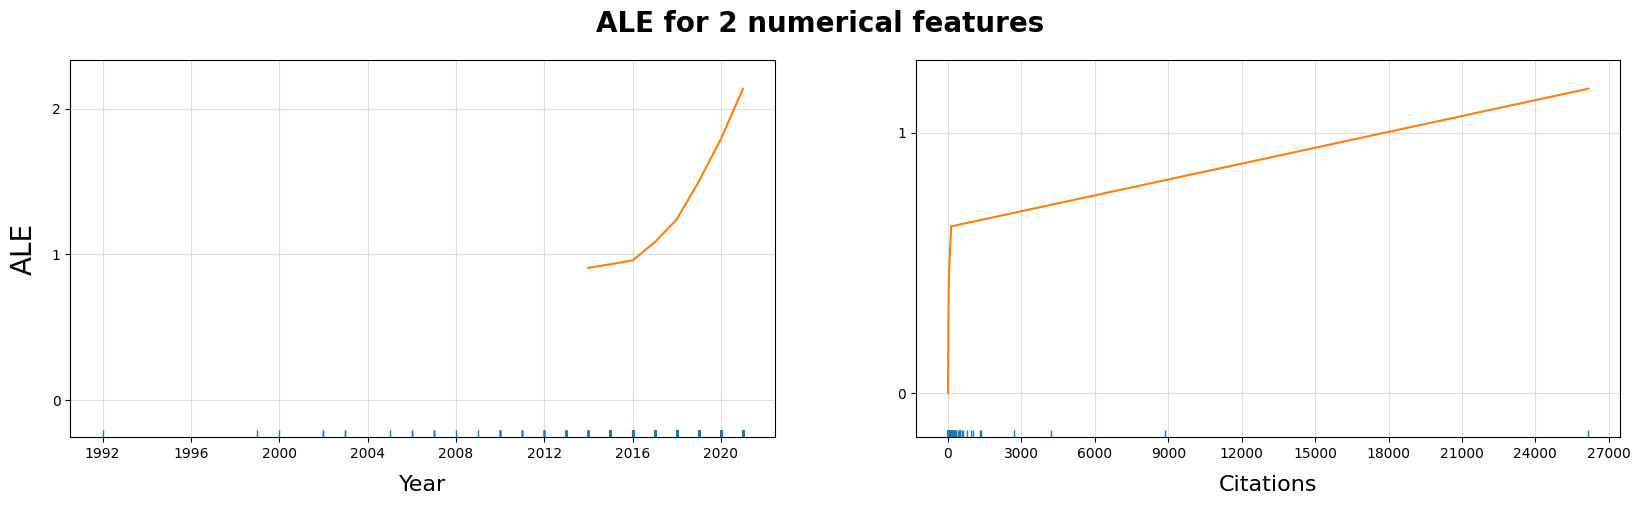

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

categorical_plot_conf = [
    {
        'xlabel': 'Title',
        'ylabel': 'ALE',
        'ale_xy': ale_xy['title']
    },
    {
        'xlabel': 'Abstract',
        'ale_xy': ale_xy['abstract']
    },    
    {
        'xlabel': 'Authors',
        'ale_xy': ale_xy['authors'],
        # 'zoom': {
        #     'inset_axes': [0.3, 0.3, 0.47, 0.47],
        #     'x_limit': [92, 95],
        #     'y_limit': [-0.005, 0.03],
        # }
    },    
    {
        'xlabel': 'Venue',
        'ale_xy': ale_xy['venue'],
        # 'zoom': {
        #     'inset_axes': [0.3, 0.3, 0.47, 0.47],
        #     'x_limit': [89, 94],
        #     'y_limit': [-1, 6],
        # }
    },
]

numerical_plot_conf = [
    {
        'xlabel': 'Year',
        'ylabel': 'ALE',
        'ale_xy': ale_xy['year'],
        'rug': True
    },
    {
        'xlabel': 'Citations',
        'ale_xy': ale_xy['n_citations'],
        # 'zoom': {
        #     'inset_axes': [0.4, 0.2, 0.47, 0.47],
        #     'x_limit': [-1000.0, 12000],
        #     'y_limit': [-0.1, 1.2],
        # },
    },
]

def pdp_plot(confs, title):
    fig, axes_list = plt.subplots(nrows=1, ncols=len(confs), figsize=(20, 5), dpi=100)
    subplot_idx = 0
    plt.suptitle(title, fontsize=20, fontweight='bold')
    # plt.autoscale(False)
    for conf in confs:
        axes = axes if len(confs) == 1 else axes_list[subplot_idx]
        
        sns.rugplot(conf['ale_xy']['rug'], ax=axes, height=0.02)

        axes.plot(conf['ale_xy']['x'], conf['ale_xy']['y'])
        axes.grid(alpha = 0.4)

        # axes.set_ylim([-2, 20])
        axes.xaxis.set_major_locator(MaxNLocator(integer=True))
        axes.yaxis.set_major_locator(MaxNLocator(integer=True))
        
        if ('ylabel' in conf):
            axes.set_ylabel(conf.get('ylabel'), fontsize=20, labelpad=10)
        
        # if ('xticks' not in conf['ale_xy'].keys()):
        #     xAxis.set_ticklabels([])

        axes.set_xlabel(conf['xlabel'], fontsize=16, labelpad=10)
        
        if not (conf['ale_xy']['weird']):
            if (conf['ale_xy']['numerical']):
                # axes.set_ylim([-1, 3])
                pass
            else:
                axes.set_ylim([-2, 20])
                
        if 'zoom' in conf:
            axins = axes.inset_axes(conf['zoom']['inset_axes']) 
            axins.xaxis.set_major_locator(MaxNLocator(integer=True))
            axins.yaxis.set_major_locator(MaxNLocator(integer=True))
            axins.plot(conf['ale_xy']['x'], conf['ale_xy']['y'])
            axins.set_xlim(conf['zoom']['x_limit'])
            axins.set_ylim(conf['zoom']['y_limit'])
            axins.grid(alpha=0.3)
            rectpatch, connects = axes.indicate_inset_zoom(axins)
            connects[0].set_visible(False)
            connects[1].set_visible(False)
            connects[2].set_visible(True)
            connects[3].set_visible(True)
            
        subplot_idx += 1

pdp_plot(categorical_plot_conf, f"ALE for {len(categorical_plot_conf)} categorical features")
plt.savefig(os.path.join('.', 'plot', f'{sample_name}-1wale-categorical.png'), facecolor='white', transparent=False, bbox_inches='tight')

pdp_plot(numerical_plot_conf, f"ALE for {len(numerical_plot_conf)} numerical features")
plt.savefig(os.path.join('.', 'plot', f'{sample_name}-1wale-numerical.png'), facecolor='white', transparent=False, bbox_inches='tight')

plt.show()
